In [1]:
import numpy as np
import os
import torch
import datetime
from args import get_parser
from utils import get_data,get_target_dims,SlidingWindowDataset,create_data_loaders

In [16]:
dataset = "SMAP"
window_size = 30
window_num = 10
normalize = False
group = 2
group_index = 2
index = 2

In [17]:
if dataset == 'SMD':
    output_path = f'output/SMD/{group}'
    (x_train, _), (x_test, y_test) = get_data(f"machine-{group_index}-{index}", normalize=normalize)
elif dataset in ['MSL', 'SMAP']:
    output_path = f'output/{dataset}'
    (x_train, _), (x_test, y_test) = get_data(dataset, normalize=normalize)
else:
    # raise Exception(f'Dataset "{dataset}" not available.')
    print('Invalid dataset')

load data of: SMAP
train:  0 None
test:  0 None
train set shape:  (135183, 25)
test set shape:  (427617, 25)
test set label shape:  (427617,)


In [18]:
x_train[:100]

array([[0.999, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.999, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.999, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       ...,
       [0.999, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.999, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.999, 0.   , 0.   , ..., 0.   , 0.   , 0.   ]])

In [11]:
log_dir = f'{output_path}/logs'
if not os.path.exists(output_path):
    os.makedirs(output_path)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
save_path = f"{output_path}/{id}"

x_train = torch.from_numpy(x_train).float()
x_test = torch.from_numpy(x_test).float()
n_features = x_train.shape[1]
target_dims = get_target_dims(dataset)

if target_dims is None:
    out_dim = n_features
    print(f"Will forecast and reconstruct all {n_features} input features")
elif type(target_dims) == int:
    print(f"Will forecast and reconstruct input feature: {target_dims}")
    out_dim = 1
else:
    print(f"Will forecast and reconstruct input features: {target_dims}")
    out_dim = len(target_dims)

Will forecast and reconstruct all 55 input features


In [12]:
train_dataset = SlidingWindowDataset(data = x_train, window_size = window_size, window_num = window_num, target_dim = target_dims)
test_dataset = SlidingWindowDataset(data = x_test, window_size = window_size, window_num = window_num, target_dim = target_dims)

In [13]:
print(len(train_dataset))

1933


In [14]:
print(len(test_dataset))

2447


D:\Lhw\Anaconda3\envs\pytorch\lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


格兰杰因果关系矩阵（p值）：
          X1        X2        X3        X4        X5
X1  0.000000  0.605560  0.098669  0.360827  0.200625
X2  0.009095  0.000000  0.498532  0.433394  0.090624
X3  0.182548  0.715554  0.000000  0.301804  0.431211
X4  0.040313  0.221411  0.091700  0.000000  0.618744
X5  0.058100  0.333694  0.563909  0.497535  0.000000


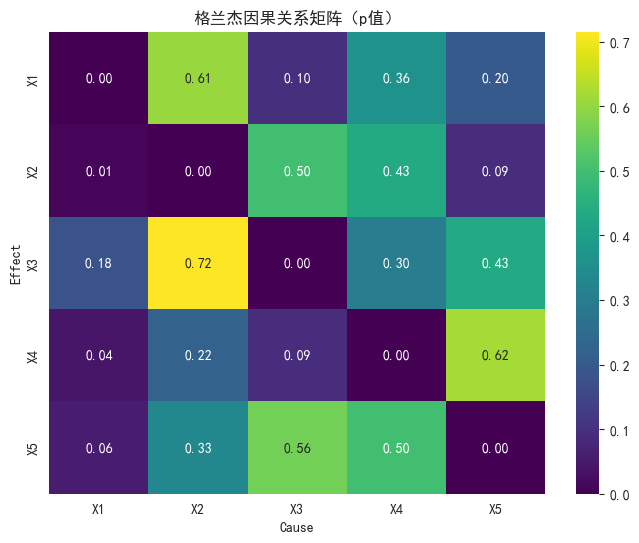

In [15]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei' 
# import warnings
# warnings.filterwarnings("ignore")

# 示例数据：N个变量，T个时间点
N = 5  # 变量数量
T = 100  # 时间点数量
data = np.random.randn(T, N)  # 随机生成时间序列数据
df = pd.DataFrame(data, columns=[f'X{i+1}' for i in range(N)])  # 转换为DataFrame

# 格兰杰因果检验
max_lag = 4  # 最大滞后阶数
causality_matrix = np.zeros((N, N))  # 初始化因果关系矩阵

# 对每对变量进行格兰杰因果检验
for i in range(N):
    for j in range(N):
        if i != j:  # 排除自身
            # 提取两个变量的时间序列
            test_data = df[[df.columns[j], df.columns[i]]]  # X_j -> X_i
            # 进行格兰杰因果检验
            test_result = grangercausalitytests(test_data, maxlag=max_lag, verbose=False)
            # 提取所有滞后阶数的p值
            p_values = [test_result[lag + 1][0]['ssr_ftest'][1] for lag in range(max_lag)]
            # 取最小p值作为因果关系的显著性
            min_p_value = min(p_values)
            causality_matrix[i, j] = min_p_value

# 输出因果关系矩阵
print("格兰杰因果关系矩阵（p值）：")
print(pd.DataFrame(causality_matrix, columns=df.columns, index=df.columns))

# 可视化因果关系矩阵
plt.figure(figsize=(8, 6))
sns.heatmap(causality_matrix, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=df.columns, yticklabels=df.columns)
plt.title("格兰杰因果关系矩阵（p值）")
plt.xlabel("Cause")
plt.ylabel("Effect")
plt.show()